In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore


pd.set_option('display.max_columns', None)

In [2]:
biometric_df = pd.read_csv("../cleaned_csv/biometric_clean.csv", parse_dates=['date'])
enrolment_df = pd.read_csv("../cleaned_csv/enrolment_clean.csv", parse_dates=['date'])
demographic_df = pd.read_csv("../cleaned_csv/demographic_clean.csv", parse_dates=['date'])

In [3]:
# Aggregate enrolment totals per state
enrolment_state = enrolment_df.groupby('state')[
    ['age_0_5', 'age_5_17', 'age_18_greater']
].sum().reset_index()

enrolment_state['total_enrolments'] = (
    enrolment_state['age_0_5'] +
    enrolment_state['age_5_17'] +
    enrolment_state['age_18_greater']
)

In [4]:
# Aggregate biometric totals per state
biometric_state = biometric_df.groupby('state')[
    ['bio_age_5_17', 'bio_age_17_']
].sum().reset_index()

biometric_state['total_biometric_updates'] = (
    biometric_state['bio_age_5_17'] +
    biometric_state['bio_age_17_']
)


In [5]:
# Merge both
state_merged = biometric_state.merge(
    enrolment_state[['state', 'total_enrolments']],
    on='state',
    how='inner'
)


In [6]:
# Normalize
state_merged['biometric_per_1L'] = (
    state_merged['total_biometric_updates'] /
    state_merged['total_enrolments']
) * 100000

state_merged.sort_values('biometric_per_1L', ascending=False).head(10)


,state,bio_age_5_17,bio_age_17_,total_biometric_updates,total_enrolments,biometric_per_1L
30,The Dadra And Nagar Haveli And Daman And Diu,16362,22906,39268,716,5.484358e+06
8,Goa,34235,34120,68355,2333,2.929919e+06
5,Chandigarh,49166,25296,74462,2723,2.734557e+06
31,Tripura,147338,144170,291508,11285,2.583146e+06
18,Maharashtra,3088342,5177673,8266015,369139,2.239269e+06
6,Chhattisgarh,793429,1511501,2304930,103219,2.233048e+06
1,Andhra Pradesh,1808517,949791,2758308,127686,2.160227e+06
11,Himachal Pradesh,181226,191742,372968,17486,2.132952e+06
25,Punjab,652258,971803,1624061,76746,2.116151e+06
19,Manipur,166465,116122,282587,13456,2.100082e+06


In [7]:
biometric_df['year'] = biometric_df['date'].dt.year

In [8]:
state_year = biometric_df.groupby(['state', 'year'])[
    ['bio_age_5_17', 'bio_age_17_']
].sum().reset_index()

state_year['total_bio'] = (
    state_year['bio_age_5_17'] +
    state_year['bio_age_17_']
)

In [9]:
# Calculate growth
state_year['growth'] = state_year.groupby('state')['total_bio'].pct_change()


In [10]:
state_year.sort_values('growth', ascending=False).head(10)


,state,year,bio_age_5_17,bio_age_17_,total_bio,growth
0,Andaman And Nicobar Islands,2025,3781,2604,6385,NaN
1,Andhra Pradesh,2025,1808517,949791,2758308,NaN
2,Arunachal Pradesh,2025,42894,29500,72394,NaN
3,Assam,2025,558451,368303,926754,NaN
4,Bihar,2025,1989067,2427229,4416296,NaN
5,Chandigarh,2025,49166,25296,74462,NaN
6,Chhattisgarh,2025,793429,1511501,2304930,NaN
7,Delhi,2025,12680,58930,71610,NaN
8,Goa,2025,34235,34120,68355,NaN
9,Gujarat,2025,1400043,1641412,3041455,NaN


In [14]:
# Create month column
biometric_df['month'] = biometric_df['date'].dt.to_period('M')


In [15]:
# Monthly aggregation per state
monthly_state = biometric_df.groupby(['state', 'month'])[
    ['bio_age_5_17', 'bio_age_17_']
].sum().reset_index()


In [16]:
# Total biometric updates per month
monthly_state['monthly_total'] = (
    monthly_state['bio_age_5_17'] +
    monthly_state['bio_age_17_']
)


In [17]:
monthly_state['z_score'] = (
    monthly_state.groupby('state')['monthly_total']
    .transform(lambda x: zscore(x, nan_policy='omit'))
)


In [18]:
monthly_state['is_anomaly'] = monthly_state['z_score'].abs() >= 2


In [19]:
anomaly_df = monthly_state.copy()


In [20]:
anomaly_summary = anomaly_df.groupby('state').agg(
    anomaly_months=('is_anomaly', 'sum'),
    avg_monthly_updates=('monthly_total', 'mean'),
    max_spike=('monthly_total', 'max')
).reset_index()

anomaly_summary.sort_values('anomaly_months', ascending=False).head(10)


,state,anomaly_months,avg_monthly_updates,max_spike
2,Arunachal Pradesh,1,8043.777778,10634
5,Chandigarh,1,8273.555556,32547
6,Chhattisgarh,1,256103.333333,438656
30,The Dadra And Nagar Haveli And Daman And Diu,1,4363.111111,6466
33,Uttarakhand,1,84837.000000,209801
9,Gujarat,1,337939.444444,517502
7,Delhi,1,7956.666667,17455
34,West Bengal,1,234471.555556,352421
24,Puducherry,1,4988.888889,8612
21,Mizoram,1,12412.888889,47132


In [21]:
anomaly_summary.to_csv("../outputs/state_anomaly_summary.csv", index=False)


In [22]:
df = pd.read_csv("../outputs/state_anomaly_summary.csv")

# Define thresholds (simple & explainable)
high_risk = (df['anomaly_months'] >= 3) | (df['max_spike'] > df['max_spike'].quantile(0.9))
medium_risk = (df['anomaly_months'] == 2)

df['risk_category'] = 'Low'
df.loc[medium_risk, 'risk_category'] = 'Medium'
df.loc[high_risk, 'risk_category'] = 'High'

df.sort_values(['risk_category', 'anomaly_months'], ascending=[True, False]).head(10)


,state,anomaly_months,avg_monthly_updates,max_spike,risk_category
32,Uttar Pradesh,1,1.056695e+06,1417324,High
4,Bihar,0,4.906996e+05,720015,High
17,Madhya Pradesh,0,6.089881e+05,923021,High
18,Maharashtra,0,9.184461e+05,1111593,High
2,Arunachal Pradesh,1,8.043778e+03,10634,Low
5,Chandigarh,1,8.273556e+03,32547,Low
6,Chhattisgarh,1,2.561033e+05,438656,Low
7,Delhi,1,7.956667e+03,17455,Low
9,Gujarat,1,3.379394e+05,517502,Low
19,Manipur,1,3.139856e+04,86754,Low


In [23]:
df.to_csv("../outputs/state_risk_classification.csv", index=False)


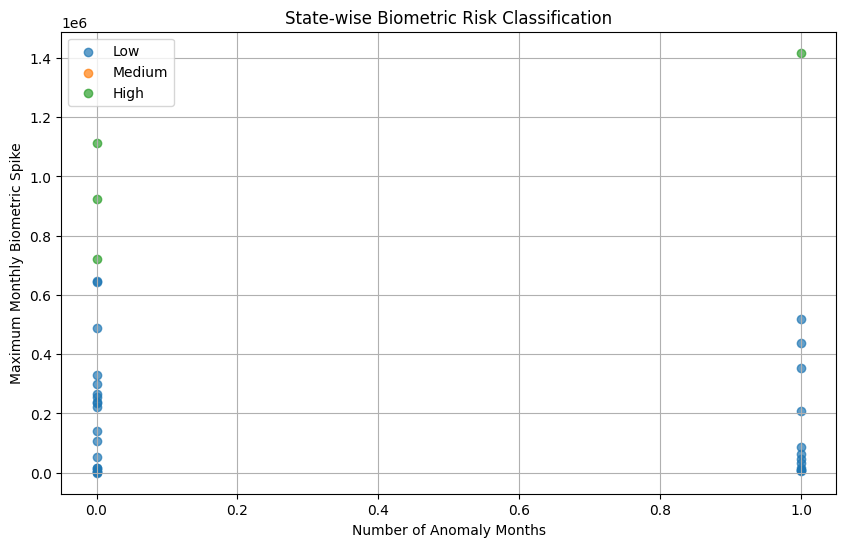

In [24]:
plt.figure(figsize=(10,6))

for category, color in zip(['Low', 'Medium', 'High'], ['green', 'orange', 'red']):
    subset = df[df['risk_category'] == category]
    plt.scatter(
        subset['anomaly_months'],
        subset['max_spike'],
        label=category,
        alpha=0.7
    )

plt.xlabel("Number of Anomaly Months")
plt.ylabel("Maximum Monthly Biometric Spike")
plt.title("State-wise Biometric Risk Classification")
plt.legend()
plt.grid(True)
plt.show()
